## Imports

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
from statsmodels.stats.moment_helpers import cov2corr
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
#!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py

In [4]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## DGP

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1} + \epsilon_{2,t} \\
\end{align*}
$

with $\beta_{1,0} = 0.8$, $\beta_{2,1} = -0.5$ and $\beta_{2,2} = 0.7$. 

$
\begin{align*}
\mathbf{\Sigma} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}
$

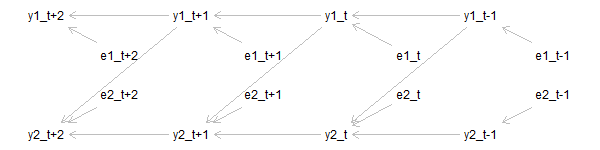

[1] "Adjustment set for direct effect:"
 { y1_t, y2_t }
 { y1_t, y1_t-1 }
[1] "----------------------------------"
[1] "Adjustment set for total effect:"
 {}


In [5]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "e1_t+2" [pos="1,2"]
    "e2_t+2" [pos="1,3"]

    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "e1_t+1" [pos="3,2"]
    "e2_t+1" [pos="3,3"]

    "y1_t" [pos="4,1"]
    "y2_t" [pos="4,4"]
    "e1_t" [pos="5,2"]
    "e2_t" [pos="5,3"]

    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "e1_t-1" [pos="7,2"]
    "e2_t-1" [pos="7,3"]    

    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "e1_t+2"
    "y1_t+1" <- "e1_t+1"
    "y1_t" <- "e1_t"
    "y1_t-1" <- "e1_t-1"

    "y2_t+2" <- "e2_t+2"
    "y2_t+1" <- "e2_t+1"
    "y2_t" <- "e2_t"
    "y2_t-1" <- "e2_t-1"

    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t" <- "y1_t-1" 
}')
plot(g)

print("Adjustment set for direct effect:")
print(adjustmentSets(g, exposure="e1_t", outcome="y2_t+1", effect="direct"))
print("----------------------------------")
print("Adjustment set for total effect:")
print(adjustmentSets(g, exposure="e1_t", outcome="y2_t+1", effect="total"))

### Simualate data according to DGP

intercept.y :0.0
intercept.y2 :0.0
L1.y.y :0.8
L1.y2.y :0.0
L1.y.y2 :-0.5
L1.y2.y2 :0.7
sqrt.var.y :1.0
sqrt.cov.y.y2 :0.0
sqrt.var.y2 :1.0


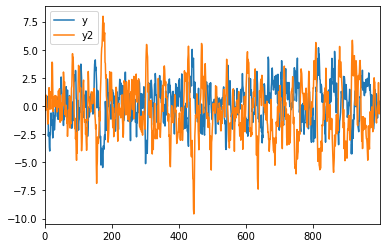

In [6]:
initial_state = [0, 0]
intercepts = np.array(
    [0, 0], #beta_01, beta_02
)
coefs = np.array([
       [0.8, 0], # beta_11, beta_12, 
       [-0.5, 0.7], # beta_21, beta_22
]).flatten(order="C")
corr = np.array([
    [1, 0.0],
    [0.0, 1],
])
stds = [1, 1] # std(e_1t), std(e_2t)
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y":[np.nan, np.nan], "y2":[np.nan, np.nan]}, index=[0, 1])

mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="c")
params = np.concatenate([intercepts, coefs, cov[np.triu_indices(cov.shape[1])]], axis=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df = pd.DataFrame(mod.simulate(params=params, nsimulations=1000, initial_state=initial_state))
_ = df.plot()

## Fit a VAR model to simulated data
We guess lags correctly and Cholesky for identification such that structural shock for $y$, $\omega_{1,t}$, does not contemporaneously affect $y2$.

In [7]:
model = sm.tsa.VAR(df)
res = model.fit(maxlags=1)
irf = res.irf(5)

### VAR results - cofficients

In [8]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Sep, 2020
Time:                     23:14:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0180542
Nobs:                     999.000    HQIC:              -0.000214638
Log likelihood:          -2823.34    FPE:                   0.988649
AIC:                   -0.0114158    Det(Omega_mle):        0.982738
--------------------------------------------------------------------
Results for equation y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.043795         0.032206            1.360           0.174
L1.y          0.807619         0.022851           35.343           0.000
L1.y2         0.015519         0.015565            0.997           0.319

Results for equation y

Estimated effect of w1_t on y2_t+1 is about -0.46, while true value is -0.5


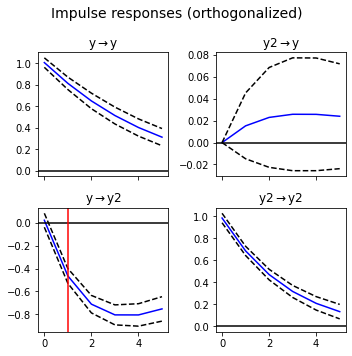

In [13]:
fig = irf.plot(orth=True)
fig.set_size_inches(5, 5)
plt.tight_layout()
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf.orth_irfs[1, 1, 0], -0.5))

### Replicate result for $\omega_{1,t}$ effect on $y_{2, t+1}$.

In [10]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["e1_l1"] = res.resid["y"].copy().shift(1)
gg["y1_l1"] = df["y"].copy().shift(1)
gg["y2_l1"] = df["y2"].copy().shift(1)
gg.dropna(inplace=True)

In [11]:
# Run OLS regression
ools_res = sm_form.ols(formula="y2 ~ e1_l1 -1", data=gg.dropna()).fit()
print(ools_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.030
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                              31.06
Date:                Fri, 04 Sep 2020   Prob (F-statistic):                    3.22e-08
Time:                        23:14:29   Log-Likelihood:                         -2299.6
No. Observations:                 998   AIC:                                      4601.
Df Residuals:                     997   BIC:                                      4606.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$?

In [12]:
# What would happen if we controlled for y1_
ools_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + e1_l1 -1", data=gg.dropna()).fit()
print(ools_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.840
Method:                 Least Squares   F-statistic:                              1747.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:14:29   Log-Likelihood:                         -1399.1
No. Observations:                 998   AIC:                                      2804.
Df Residuals:                     995   BIC:                                      2819.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------